# NF2

In [ ]:
from setproctitle import setproctitle
setproctitle("NF2")

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
import shutil
import glob
import torch
import numpy as np

In [ ]:
import numpy as np
import torch
from astropy.nddata import block_replicate
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


class PotentialModel(nn.Module):

    def __init__(self, b_n, r_p):
        super().__init__()
        self.register_buffer('b_n', b_n)
        self.register_buffer('r_p', r_p)
        c = np.zeros((1, 3))
        c[:, 2] = (1 / np.sqrt(2 * np.pi))
        c = torch.tensor(c, dtype=torch.float32, )
        self.register_buffer('c', c)

    def forward(self, coord):
        v1 = self.b_n[:, None]
        v2 = 2 * np.pi * ((-self.r_p[:, None] + coord[None, :] + self.c[None]) ** 2).sum(-1) ** 0.5
        potential = torch.sum(v1 / v2, dim=0)
        return potential


def get_potential(b_n, height, batch_size=2048, strides=(1, 1, 1), progress=True):
    cube_shape = (*b_n.shape, height)
    strides = (strides, strides, strides) if isinstance(strides, int) else strides
    b_n = b_n.reshape((-1,)).astype(np.float32)
    coords = np.stack(np.mgrid[:cube_shape[0]:strides[0], :cube_shape[1]:strides[1], :cube_shape[2]:strides[2]], -1).reshape((-1, 3))
    r_p = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], :1], -1).reshape((-1, 3))

    # torch code
    # r = (x * y, 3); coords = (x*y*z, 3), c = (1, 3)
    # --> (x * y, x * y * z, 3) --> (x * y, x * y * z) --> (x * y * z)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        b_n = torch.tensor(b_n, dtype=torch.float32, )
        r_p = torch.tensor(r_p, dtype=torch.float32, )
        model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)

        coords = torch.tensor(coords, dtype=torch.float32)
        potential = []
        loader = DataLoader(TensorDataset(coords), batch_size=batch_size, num_workers=8)
        it = tqdm(loader, desc='Potential Field') if progress else loader
        for coord, in it:
            coord = coord.to(device)
            p_batch = model(coord)
            potential += [p_batch]

    potential = torch.cat(potential).view(cube_shape).cpu().numpy()
    if strides != (1, 1, 1):
        potential = block_replicate(potential, strides, conserve_sum=False)
    return potential

def get_potential_field(b_n, height, *args, **kwargs):
    potential = get_potential(b_n, height, *args, **kwargs)
    b = - 1 * np.stack(np.gradient(potential, axis=[0, 1, 2], edge_order=2), axis=-1)
    return b

def get_potential_boundary(b_n, height, batch_size=2048, **kwargs):
    assert not np.any(np.isnan(b_n)), 'Invalid data value'

    cube_shape = (*b_n.shape, height)

    b_n = b_n.reshape((-1)).astype(np.float32)
    coords = [np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], cube_shape[2] - 2:cube_shape[2] + 1], -1),
              np.stack(np.mgrid[:cube_shape[0], -1:2, :cube_shape[2]], -1),
              np.stack(np.mgrid[:cube_shape[0], cube_shape[1] - 2:cube_shape[1] + 1, :cube_shape[2]], -1),
              np.stack(np.mgrid[-1:2, :cube_shape[1], :cube_shape[2]], -1),
              np.stack(np.mgrid[cube_shape[0] - 2:cube_shape[0] + 1, :cube_shape[1], :cube_shape[2]], -1), ]
    fields = _compute_fields(coords, cube_shape, b_n, batch_size=batch_size, **kwargs)

    fields = [fields[0][:, :, 1].reshape((-1, 3)),
              fields[1][:, 1, :].reshape((-1, 3)), fields[2][:, 1, :].reshape((-1, 3)),
              fields[3][1, :, :].reshape((-1, 3)), fields[4][1, :, :].reshape((-1, 3))]
    coords = [coords[0][:, :, 1].reshape((-1, 3)),
              coords[1][:, 1, :].reshape((-1, 3)), coords[2][:, 1, :].reshape((-1, 3)),
              coords[3][1, :, :].reshape((-1, 3)), coords[4][1, :, :].reshape((-1, 3))]
    return np.concatenate(coords), np.concatenate(fields)


def get_potential_top(b_n, height, batch_size=2048, **kwargs):
    assert not np.any(np.isnan(b_n)), 'Invalid data value'

    cube_shape = (*b_n.shape, height)

    b_n = b_n.reshape((-1)).astype(np.float32)
    coords = [np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], cube_shape[2] - 2:cube_shape[2] + 1], -1)]
    fields = _compute_fields(coords, cube_shape, b_n, batch_size=batch_size, **kwargs)

    fields = [fields[0][:, :, 1].reshape((-1, 3)),]
    coords = [coords[0][:, :, 1].reshape((-1, 3)),]
    return np.concatenate(coords), np.concatenate(fields)

def _compute_fields(coords, cube_shape, b_n, batch_size=2048, progress=False):
    coords_shape = [c.shape[:-1] for c in coords]
    flat_coords = np.concatenate([c.reshape(((-1, 3))) for c in coords])

    r_p = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], :1], -1).reshape((-1, 3))

    # torch code
    # r = (x * y, 3); coords = (x*y*z, 3), c = (1, 3)
    # --> (x * y, x * y * z, 3) --> (x * y, x * y * z) --> (x * y * z)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        b_n = torch.tensor(b_n, dtype=torch.float32, )
        r_p = torch.tensor(r_p, dtype=torch.float32, )
        model = nn.DataParallel(PotentialModel(b_n, r_p, )).to(device)

        flat_coords = torch.tensor(flat_coords, dtype=torch.float32, )

        potential = []
        iter = DataLoader(TensorDataset(flat_coords), batch_size=batch_size, num_workers=2)
        iter = iter if progress else tqdm(iter, desc='Potential Field')
        for coord, in iter:
            coord = coord.to(device)
            p_batch = model(coord)
            potential += [p_batch.cpu()]

    potential = torch.cat(potential).numpy()
    idx = 0
    fields = []
    for s in coords_shape:
        p = potential[idx:idx + np.prod(s)].reshape(s)
        b = - 1 * np.stack(np.gradient(p, axis=[0, 1, 2], edge_order=2), axis=-1)
        fields += [b]
        idx += np.prod(s)

    return fields

In [ ]:
import numpy as np

def divergence(b_field):  # (x, y, z, (xyz-field))
    div_B = np.stack([np.gradient(b_field[..., i], axis=i, edge_order=2) for i in range(3)], axis=-1).sum(-1)
    return div_B


def curl(b_field):  # (x, y, z)
    _, dFx_dy, dFx_dz = np.gradient(b_field[..., 0], axis=[0, 1, 2], edge_order=2)
    dFy_dx, _, dFy_dz = np.gradient(b_field[..., 1], axis=[0, 1, 2], edge_order=2)
    dFz_dx, dFz_dy, _ = np.gradient(b_field[..., 2], axis=[0, 1, 2], edge_order=2)

    rot_x = dFz_dy - dFy_dz
    rot_y = dFx_dz - dFz_dx
    rot_z = dFy_dx - dFx_dy

    return np.stack([rot_x, rot_y, rot_z], -1)


def lorentz_force(b_field, j_field=None):
    j_field = j_field if j_field is not None else curl(b_field)
    l = np.cross(j_field, b_field, axis=-1)
    return l


def vector_norm(vector):
    return np.sqrt((vector ** 2).sum(-1))


def angle(b_field, j_field):
    norm = vector_norm(b_field) * vector_norm(j_field) + 1e-7
    j_cross_b = np.cross(j_field, b_field, axis=-1)
    sig = vector_norm(j_cross_b) / norm
    return np.arcsin(np.clip(sig, -1. + 1e-7, 1. - 1e-7)) * (180 / np.pi)


def normalized_divergence(b_field):
    return np.abs(divergence(b_field)) / (vector_norm(b_field) + 1e-7)


def weighted_theta(b, j=None):
    j = j if j is not None else curl(b)
    sigma = vector_norm(lorentz_force(b, j)) / vector_norm(b) / vector_norm(j)
    w_sigma = np.average((sigma), weights=vector_norm(j))
    theta_j = np.arcsin(w_sigma) * (180 / np.pi)
    return theta_j


def energy(b):
    return (b ** 2).sum(-1) / (8 * np.pi)


def evaluate(b, B):
    result = {}
    result['c_vec'] = np.sum((B * b).sum(-1)) / np.sqrt((B ** 2).sum(-1).sum() * (b ** 2).sum(-1).sum())
    M = np.prod(B.shape[:-1])
    result['c_cs'] = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))

    result['E_n'] = vector_norm(b - B).sum() / vector_norm(B).sum()

    result['E_m'] = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()

    result['eps'] = (vector_norm(b) ** 2).sum() / (vector_norm(B) ** 2).sum()

    B_potential = get_potential_field(B[:, :, 0, 2], 64)

    result['eps_p'] = (vector_norm(b) ** 2).sum() / (vector_norm(B_potential) ** 2).sum()
    result['eps_p_ll'] = (vector_norm(B) ** 2).sum() / (vector_norm(B_potential) ** 2).sum()

    j = curl(b)
    result['sig_J'] = (vector_norm(np.cross(j, b, -1)) / vector_norm(b)).sum() / vector_norm(j).sum() * 1e2
    J = curl(B)
    result['sig_J_ll'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / vector_norm(J).sum() * 1e2

    result['L1'] = (vector_norm(np.cross(j, b, -1)) ** 2 / vector_norm(b) ** 2).mean()
    result['L2'] = (divergence(b) ** 2).mean()

    result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()
    result['L2_B'] = (divergence(B) ** 2).mean()

    result['L2n'] = (np.abs(divergence(b)) / vector_norm(b)).mean() * 1e2
    result['L2n_B'] = (np.abs(divergence(B)) / vector_norm(B)).mean() * 1e2

    return result

In [ ]:
import numpy as np

def get_free_mag_energy(b, **kwargs):
    b_potential = get_potential_field(b[:, :, 0, 2], b.shape[2], batch_size=int(1e3), **kwargs)
    #
    free_energy = energy(b) - energy(b_potential)
    return free_energy

In [ ]:
import os

import numpy as np
import torch
from astropy.io import fits
from matplotlib import pyplot as plt
from sunpy.map import Map
from torch import nn
from tqdm import tqdm

def load_cube(save_path, device=None, z=None, strides=1, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    model = nn.DataParallel(state['model'])
    cube_shape = state['cube_shape']
    z = z if z is not None else cube_shape[2]
    coords = np.stack(np.mgrid[:cube_shape[0]:strides, :cube_shape[1]:strides, :z:strides], -1)
    return load_coords(model, cube_shape, state['spatial_norm'],
                       state['b_norm'], coords, device, **kwargs)

def load_height_surface(save_path, device=None, strides=1, batch_size=1000, progress=False, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    model = state['height_mapping_model']
    height_mapping = state['height_mapping']
    assert model is not None, 'Requires height mapping model!'
    model = nn.DataParallel(model)
    cube_shape = state['cube_shape']
    coords = np.stack(np.mgrid[:cube_shape[0]:strides, :cube_shape[1]:strides, :len(height_mapping['z']):], -1)
    ranges = np.zeros((*coords.shape[:-1], 2))
    for i, (z, z_min, z_max) in enumerate(zip(height_mapping['z'], height_mapping['z_min'], height_mapping['z_max'])):
        coords[:, :, i, 2] = z
        ranges[:, :, i, 0] = z_min
        ranges[:, :, i, 1] = z_max

    # normalize and to tensor
    coords = torch.tensor(coords / state['spatial_norm'], dtype=torch.float32)
    coords_shape = coords.shape
    coords = coords.view((-1, 3))

    ranges = torch.tensor(ranges / state['spatial_norm'], dtype=torch.float32)
    ranges = ranges.view((-1, 2))

    slices = []
    it = range(int(np.ceil(coords.shape[0] / batch_size)))
    it = tqdm(it) if progress else it
    for k in it:
        coord = coords[k * batch_size: (k + 1) * batch_size]
        coord = coord.to(device)
        coord.requires_grad = True
        #
        r = ranges[k * batch_size: (k + 1) * batch_size]
        r = r.to(device)
        slices += [model(coord, r).detach().cpu()]

    slices = torch.cat(slices) * state['spatial_norm']
    slices = slices.view(*coords_shape).numpy()
    return slices

def load_height_cube(save_path, *args, device=None, strides=1, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    cube_shape = state['cube_shape']

    slice = load_height_surface(save_path, *args, device=device, strides=strides, **kwargs)

    cube = np.stack(np.mgrid[:cube_shape[0]:strides, :cube_shape[1]:strides, :cube_shape[2]:strides], -1)[..., 2]
    contour_cube = np.zeros_like(cube)
    for i in range(slice.shape[2]):
        contour_cube[cube > slice[:, :, i:i+1, 2]] = i + 1
    return contour_cube

def load_shape(save_path, device=None):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    return state['cube_shape']


def load_slice(save_path, z=0, device=None, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    model = nn.DataParallel(state['model'])
    cube_shape = state['cube_shape']
    z = z if z is not None else cube_shape[2]
    coords = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], z:z + 1], -1)
    return load_coords(model, cube_shape, state['spatial_norm'],
                       state['b_norm'], coords, device, **kwargs)


def load_coords_from_state(save_path, coords, device=None, **kwargs):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    state = torch.load(save_path, map_location=device)
    model = nn.DataParallel(state['model'])
    cube_shape = state['cube_shape']
    return load_coords(model, cube_shape, state['spatial_norm'], state['b_norm'], coords, device,
                       **kwargs)


def load_coords(model, cube_shape, spatial_norm, b_norm, coords, device, batch_size=1000, progress=False):
    assert np.all(coords[..., 0] < cube_shape[0]), 'Invalid x coordinate, maximum is %d' % cube_shape[0]
    assert np.all(coords[..., 1] < cube_shape[1]), 'Invalid x coordinate, maximum is %d' % cube_shape[1]
    assert np.all(coords[..., 2] < cube_shape[2]), 'Invalid x coordinate, maximum is %d' % cube_shape[2]

    def _load(coords):
        # normalize and to tensor
        coords = torch.tensor(coords / spatial_norm, dtype=torch.float32)
        coords_shape = coords.shape
        coords = coords.view((-1, 3))

        cube = []
        it = range(int(np.ceil(coords.shape[0] / batch_size)))
        it = tqdm(it) if progress else it
        for k in it:
            coord = coords[k * batch_size: (k + 1) * batch_size]
            coord = coord.to(device)
            coord.requires_grad = True
            cube += [model(coord).detach().cpu()]

        cube = torch.cat(cube)
        cube = cube.view(*coords_shape).numpy()
        b = cube * b_norm
        return b
    if isinstance(model, VectorPotentialModel) or \
            (isinstance(model, nn.DataParallel) and isinstance(model.module, VectorPotentialModel)):
        return _load(coords)
    else:
        with torch.no_grad():
            return _load(coords)

def load_B_map(nf2_file, component=2):
    state = torch.load(nf2_file)
    meta = state['meta_data']
    mag_data = load_slice(nf2_file, z=0)
    mag_map = Map(mag_data[:, :, 0, component].T, meta)
    return mag_map


def save_fits(vec, path, prefix, meta_info={}):
    hdu = fits.PrimaryHDU(vec[..., 0].T)
    for i, v in meta_info.items():
        hdu.header[i] = v
    hdul = fits.HDUList([hdu])
    x_path = os.path.join(path, '%s_Bx.fits' % prefix)
    hdul.writeto(x_path)

    hdu = fits.PrimaryHDU(vec[..., 1].T)
    for i, v in meta_info.items():
        hdu.header[i] = v
    hdul = fits.HDUList([hdu])
    y_path = os.path.join(path, '%s_By.fits' % prefix)
    hdul.writeto(y_path)

    hdu = fits.PrimaryHDU(vec[..., 2].T)
    for i, v in meta_info.items():
        hdu.header[i] = v
    hdul = fits.HDUList([hdu])
    z_path = os.path.join(path, '%s_Bz.fits' % prefix)
    hdul.writeto(z_path)
    return x_path, y_path, z_path


def save_slice(b, file_path, v_min_max=None):
    v_min_max = np.abs(b).max() if v_min_max is None else v_min_max
    plt.imsave(file_path, b.transpose(), cmap='gray', vmin=-v_min_max, vmax=v_min_max, origin='lower')


In [ ]:
import torch
from torch import nn
from torch.nn import Embedding

class Sine(nn.Module):
    def __init__(self, w0=1.):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class HeightMappingModel(nn.Module):

    def __init__(self, in_coords, dim, positional_encoding=True):
        super().__init__()
        if positional_encoding:
            posenc = PositionalEncoding(8, 20)
            d_in = nn.Linear(in_coords * 40, dim)
            self.d_in = nn.Sequential(posenc, d_in)
        else:
            self.d_in = nn.Linear(in_coords, dim)
        lin = [nn.Linear(dim, dim) for _ in range(4)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(dim, 1)
        self.activation = Sine()

    def forward(self, x, height_range):
        input_coords = x
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        z_coords = torch.sigmoid(self.d_out(x)) * (height_range[:, 1:2] - height_range[:, 0:1]) + height_range[:, 0:1]
        # shifted_z_coords = input_coords[:, 2:3] * (1 + z_shift) # max shift in dependence of height estimate
        output_coords = torch.cat([input_coords[:, :2], z_coords], -1)
        return output_coords

class BModel(nn.Module):

    def __init__(self, in_coords, out_values, dim, pos_encoding=False):
        super().__init__()
        if pos_encoding:
            posenc = PositionalEncoding(8, 20)
            d_in = nn.Linear(in_coords * 40, dim)
            self.d_in = nn.Sequential(posenc, d_in)
        else:
            self.d_in = nn.Linear(in_coords, dim)
        lin = [nn.Linear(dim, dim) for _ in range(8)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(dim, out_values)
        self.activation = Sine()  # torch.tanh

    def forward(self, x):
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        x = self.d_out(x)
        return x

class VectorPotentialModel(nn.Module):

    def __init__(self, in_coords, dim, pos_encoding=False):
        super().__init__()
        if pos_encoding:
            posenc = PositionalEncoding(8, 20)
            d_in = nn.Linear(in_coords * 40, dim)
            self.d_in = nn.Sequential(posenc, d_in)
        else:
            self.d_in = nn.Linear(in_coords, dim)
        lin = [nn.Linear(dim, dim) for _ in range(8)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(dim, 3)
        self.activation = Sine()  # torch.tanh

    def forward(self, x):
        coord = x
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        a = self.d_out(x)
        #
        jac_matrix = jacobian(a, coord)
        dAy_dx = jac_matrix[:, 1, 0]
        dAz_dx = jac_matrix[:, 2, 0]
        dAx_dy = jac_matrix[:, 0, 1]
        dAz_dy = jac_matrix[:, 2, 1]
        dAx_dz = jac_matrix[:, 0, 2]
        dAy_dz = jac_matrix[:, 1, 2]
        rot_x = dAz_dy - dAy_dz
        rot_y = dAx_dz - dAz_dx
        rot_z = dAy_dx - dAx_dy
        b = torch.stack([rot_x, rot_y, rot_z], -1)
        #
        return b

class PositionalEncoding(nn.Module):
    """
    Positional Encoding of the input coordinates.

    encodes x to (..., sin(2^k x), cos(2^k x), ...)
    k takes "num_freqs" number of values equally spaced between [0, max_freq]
    """

    def __init__(self, max_freq, num_freqs):
        """
        Args:
            max_freq (int): maximum frequency in the positional encoding.
            num_freqs (int): number of frequencies between [0, max_freq]
        """
        super().__init__()
        freqs = 2 ** torch.linspace(0, max_freq, num_freqs)
        self.register_buffer("freqs", freqs)  # (num_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (batch, num_samples, in_features)
        Outputs:
            out: (batch, num_samples, 2*num_freqs*in_features)
        """
        x_proj = x.unsqueeze(dim=-2) * self.freqs.unsqueeze(dim=-1)  # (num_rays, num_samples, num_freqs, in_features)
        x_proj = x_proj.reshape(*x.shape[:-1], -1)  # (num_rays, num_samples, num_freqs*in_features)
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)],
                        dim=-1)  # (num_rays, num_samples, 2*num_freqs*in_features)
        return out


def jacobian(output, coords):
    jac_matrix = [torch.autograd.grad(output[:, i], coords,
                                      grad_outputs=torch.ones_like(output[:, i]).to(output),
                                      retain_graph=True, create_graph=True, allow_unused=True)[0]
                  for i in range(output.shape[1])]
    jac_matrix = torch.stack(jac_matrix, dim=1)
    return jac_matrix

In [ ]:
import argparse
import glob
import os

import imageio
import numpy as np
import torch.cuda
from dateutil.parser import parse
from matplotlib import pyplot as plt, cm
from matplotlib.colors import Normalize
from matplotlib.dates import date2num, DateFormatter
from sunpy.net import Fido
from sunpy.net import attrs as a
from tqdm import tqdm

def evaluate_nf2(nf2_file, z, cm_per_pixel, strides, batch_size):
    b = load_cube(nf2_file, progress=False, z=z, strides=strides, batch_size=batch_size)
    j = curl(b)
    jxb = np.cross(j, b, axis=-1)
    me = energy(b)
    free_me = get_free_mag_energy(b, progress=False)
    theta = weighted_theta(b, j)

    result = {
        'date': parse(os.path.basename(nf2_file).split('.')[0][:-4].replace('_', 'T')),
        # torch.load(nf2_file)['meta_data']['DATE-OBS'],
        # bottom boundary
        'b_0': b[:, :, 0, 2],
        # integrated quantities
        'total_energy': me.sum() * cm_per_pixel ** 3,
        'total_free_energy': free_me.sum() * cm_per_pixel ** 3,
        'total_div': (np.abs(divergence(b)) / vector_norm(b)).mean(),
        'total_jxb': vector_norm(jxb).mean(),
        'theta': theta,
        # heigth distribution
        'height_free_energy': free_me.mean((0, 1)),
        # maps
        'j_map': vector_norm(j).sum(2),
        'energy_map': me.sum(2) * cm_per_pixel,
        'free_energy_map': free_me.sum(2) * cm_per_pixel,
        'jxb_map': vector_norm(jxb).sum(2),
    }
    return result


def evaluate_nf2_series(nf2_paths, z, cm_per_pixel, strides, batch_size):
    results = []
    for nf2_file in tqdm(nf2_paths):
        results.append(evaluate_nf2(nf2_file, z, cm_per_pixel, strides, batch_size))
    # concatenate dicts to dict of lists
    results = {k: [r[k] for r in results] for k in results[0].keys()}
    return results

In [ ]:
zip_path = '/userhome/jeon_mg/workspace/_data/_NF2/7115_series.zip'
base_path = '/userhome/jeon_mg/workspace/_data/_NF2/AR7115'

In [ ]:
shutil.unpack_archive(zip_path, base_path)

In [ ]:
batch_size = 10000

In [ ]:
nf2_files = sorted(glob.glob(os.path.join(base_path, '*.nf2')))
nf2_files = [f for f in nf2_files if 'extrapolation_result.nf2' not in f] # filter the initial state

state = torch.load(nf2_files[0])
Mm_per_pix = state['Mm_per_pixel']
cm_per_pix = (Mm_per_pix * 1e8)
z_pixels = int(np.ceil(20 / (Mm_per_pix)))

In [ ]:
Mm_per_pix

0.72

In [ ]:
series_results = evaluate_nf2_series(nf2_files, z_pixels, cm_per_pix, 2, batch_size)

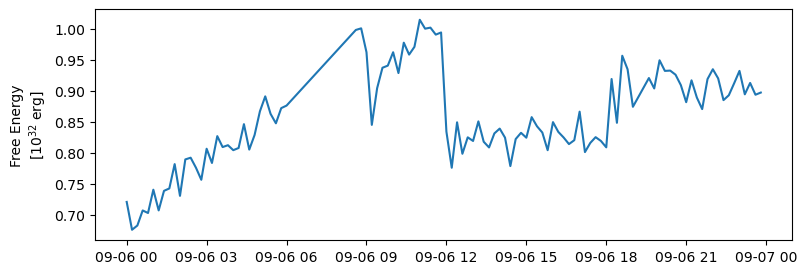

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(series_results['date'], np.array(series_results['total_free_energy']) * 1e-32)
plt.ylabel('Free Energy\n[$10^{32}$ erg]')
plt.show()

In [ ]:
from sunpy.net import Fido
from sunpy.net import attrs as a

In [ ]:
dates = [parse(os.path.basename(nf2_file).split('.')[0][:-4].replace('_', 'T')) for nf2_file in nf2_files]

In [ ]:
flares = Fido.search(a.Time(min(dates), max(dates)),
                     a.hek.EventType("FL"),
                     a.hek.OBS.Observatory == "GOES")["hek"]

In [ ]:
flares[['event_starttime', 'fl_goescls']]

event_starttime,fl_goescls
Time,str4
2017-09-06 06:17:00.000,C1.6
2017-09-06 07:29:00.000,C2.7
2017-09-06 08:57:00.000,X2.2
2017-09-06 11:53:00.000,X9.3
2017-09-06 15:51:00.000,M2.5
2017-09-06 19:21:00.000,M1.4
2017-09-06 23:33:00.000,M1.2


In [ ]:
flare = list(flares)[3] # select flare

In [ ]:
import drms

In [ ]:
download_dir = '/userhome/jeon_mg/workspace/_data/_NF2/EUV'

In [ ]:
client = drms.Client(email='mgjeon@khu.ac.kr', verbose=True)

In [ ]:
import os


def download_HARP(harpnum, time, dir, client, series='sharp_cea_720s'):
    ds = 'hmi.%s[%d][%s]{Br, Bp, Bt, Br_err, Bp_err, Bt_err}' % (
    series, harpnum, time.isoformat('_', timespec='seconds'))
    donwload_ds(ds, dir, client)

def download_HARP_series(harpnum, t_start, duration, download_dir, client, series='sharp_cea_720s', download_error=True):
    segments = 'Br, Bp, Bt, Br_err, Bp_err, Bt_err' if download_error else 'Br, Bp, Bt'
    ds = 'hmi.%s[%d][%s/%s]{%s}' % \
         (series, harpnum, t_start.isoformat('_', timespec='seconds'), duration, segments)
    donwload_ds(ds, download_dir, client)

def donwload_ds(ds, dir, client):
    os.makedirs(dir, exist_ok=True)
    r = client.export(ds, protocol='fits')
    r.wait()
    download_result = r.download(dir)
    return download_result


def find_HARP(start_time, noaa_nums, client):
    ar_mapping = client.query('hmi.Mharp_720s[][%sZ]' % start_time.isoformat('_', timespec='seconds'),
                              key=['NOAA_AR', 'HARPNUM'])
    if len(ar_mapping) == 0:
        return None
    for noaa_num in noaa_nums:
        harpnum = ar_mapping[ar_mapping['NOAA_AR'] == int(noaa_num)]['HARPNUM']
        if len(harpnum) > 0:
            return harpnum.iloc[0]
    return None


def download_euv(start_time, end_time, dir, client):
    ds = f'aia.lev1_euv_12s[{start_time.isoformat("_", timespec="seconds")} / {(end_time - start_time).total_seconds()}s@60s][94]{{image}}'
    euv_files = donwload_ds(ds, dir, client).download
    return euv_files

In [ ]:
start_time = flare["event_starttime"].datetime
end_time = flare["event_endtime"].datetime
euv_files = download_euv(start_time, end_time, download_dir, client=client)

Export request pending. [id=JSOC_20230716_113, status=2]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230716_113, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230716_113, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230716_113, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230716_113, status=1]
Waiting for 5 seconds...
    record: aia.lev1_euv_12s[2017-09-06T11:52:59Z][94]
  filename: aia.lev1_euv_12s.2017-09-06T115301Z.94.image_lev1.fits
  -> ../../_data/_NF2/EUV/aia.lev1_euv_12s.2017-09-06T115301Z.94.image_lev1.fits
    record: aia.lev1_euv_12s[2017-09-06T11:53:59Z][94]
  filename: aia.lev1_euv_12s.2017-09-06T115401Z.94.image_lev1.fits
  -> ../../_data/_NF2/EUV/aia.lev1_euv_12s.2017-09-06T115401Z.94.image_lev1.fits
    record: aia.lev1_euv_12s[2017-09-06T11:54:59Z][94]
  filename: aia.lev1_euv_12s.2017-09-06T115501Z.94.image_lev1.fits
  -> ../../_data/_NF2/EUV/aia.lev1_euv_12s.2017-09-06T115501Z.

In [ ]:
from datetime import datetime, timedelta

In [ ]:
import argparse
import glob
import os
from datetime import timedelta
from multiprocessing import Pool

import drms
import matplotlib.pyplot as plt
import numpy as np
import torch
from astropy.visualization import ImageNormalize, AsinhStretch
from dateutil.parser import parse
from sunpy.map import Map
from sunpy.net import Fido
from sunpy.net import attrs as a
from tqdm import tqdm

def _calculate_free_energy(nf2_file, z, batch_size):
    b = load_cube(nf2_file, progress=False, z=z, batch_size=batch_size)
    free_me = get_free_mag_energy(b, progress=False)
    return free_me


class _F:
    def __init__(self, ref_wcs):
        self.ref_wcs = ref_wcs

    def func(self, file):
        return Map(file).reproject_to(self.ref_wcs)


def get_integrated_euv_map(euv_files, ref_wcs):
    with Pool(os.cpu_count()) as p:
        reprojected_maps = p.map(_F(ref_wcs).func, euv_files)
    integrated_euv = np.array([m.data for m in reprojected_maps]).sum(0)
    euv_map = Map(integrated_euv, mag_map.meta)
    return euv_map

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


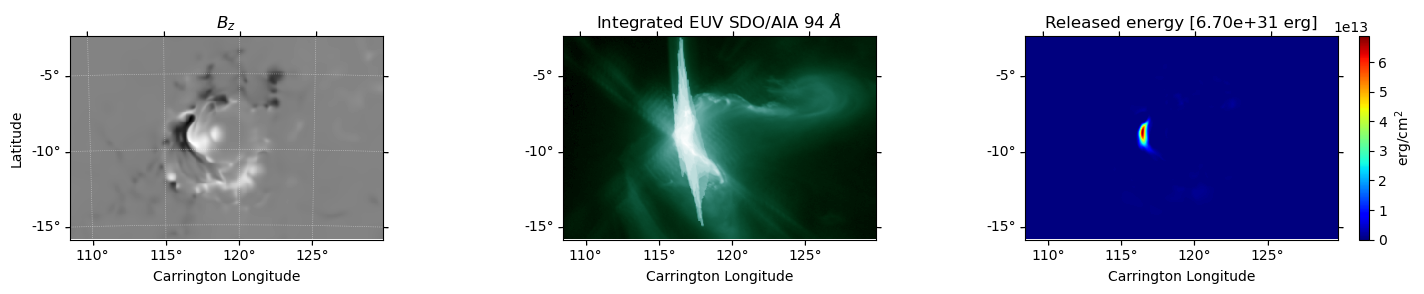

In [ ]:
filter_dates = (np.array(dates) > (start_time - timedelta(minutes=12))) & \
                (np.array(dates) < (end_time + timedelta(minutes=12)))
flare_nf2_files = np.array(nf2_files)[filter_dates]

free_energy_0 = _calculate_free_energy(flare_nf2_files[0], z_pixels, batch_size)
free_energy_1 = _calculate_free_energy(flare_nf2_files[-1], z_pixels, batch_size)
released_energy = -np.clip(free_energy_0 - free_energy_1, a_min=None, a_max=0)
released_energy_map = released_energy.sum(2) * cm_per_pix

mag_map = load_B_map(flare_nf2_files[0])
euv_map = get_integrated_euv_map(euv_files, mag_map.wcs)

plt.figure(figsize=(15, 3))

plt.subplot(131, projection=mag_map)
mag_map.plot()
plt.title('$B_z$')

plt.subplot(132, projection=euv_map)
plt.imshow(euv_map.data, origin='lower', cmap='sdoaia94', norm=ImageNormalize(stretch=AsinhStretch(0.005)))
plt.title('Integrated EUV SDO/AIA 94 $\AA$')
plt.xlabel('Carrington Longitude')
plt.ylabel(' ')

plt.subplot(133, projection=mag_map)
im = plt.imshow(released_energy_map.T, origin='lower', cmap='jet')
plt.title(f'Released energy [{released_energy.sum() * cm_per_pix ** 3:.2e} erg]')
plt.xlabel('Carrington Longitude')
plt.ylabel(' ')
plt.colorbar(mappable=im, label='erg/cm$^2$')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
flares = Fido.search(a.Time(min(series_results['date']), max(series_results['date'])),
                        a.hek.EventType("FL"),
                        a.hek.OBS.Observatory == "GOES")["hek"]

flares

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs
str1,str1,str125,str5,str21,str12,object,str29,object,str1,object,str27,str41,Time,str1,str2,object,object,float64,str25,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str95,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str4,object,str4,str4,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str1,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str4,object,str19,str11,object,str20,str1,object,str1,str1,str2,str66,str4,float64,int64,object,float64,str1,str1,object,str5,int64,float64,object,int64,str1,str1,int64,str4,str1,str1,str4,int64,str1,str19,Time,object,int64,object,int64,str4,object,str5,str1,str1,object,float64,float64,Time,int64,str1,str4,str13,str1,object,object,str1,str1,object,str1,str3,object,str66,str1,str1,object[2]
,0,"POLYGON((460.844082 -291.607332,474.970854 -290.565984,476.59605 -274.687038,462.421002 -275.731326,460.844082 -291.607332))",false,POINT(115.396602 -11),UTC-HGS-TOPO,None,POINT(468.743958 -283.162764),None,,None,"SSWIDL get_gev, ..., ngdc=0",POINT(0.575595324270699 238.864314986155),2017-09-06 06:17:00.000,,FL,None,None,5e-08,http://www.swpc.noaa.gov/,,,false,,true,None,None,,,None,,0103000000010000000500000090F98040E77B7B40768F6CAE9A8273C090F98040E77B7B40EC1ED95C35C56FC090F98040E71B7F40EC1ED95C35C56FC090F98040E71B7F40768F6CAE9A8273C090F98040E77B7B40768F6CAE9A8273C0,"POLYGON((114.896602 -11.5,115.896602 -11.5,115.896602 -10.5,114.896602 -10.5,114.896602 -11.5))",None,,XRA,,,SOL2017-09-06T06:17:00L115C101,None,9,,,,SWPC.Webmaster@noaa.gov,,None,None,SWPC,None,SWPC,GOES,,-10.5,,-11.5,"U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center","POLYGON((0.573201 237.675686,0.58523 238.543565,0.578175 240.04292,0.565877 239.193319,0.573201 237.675686))",,,,None,,0.432000000000000051,None,None,None,,,,None,None,2017-09-06T00:00:00,degrees,-283.162764,468.743958,GOES,None,2017-09-06T17:36:01,cheung_mark,None,1.24092522475061484,,None,,,cm,ivo://helio-informatics.org/FL_SWPC_20170906_173600_20170906061700,SWPC,30.5,12673,None,29.5,,,None,false,1,0.575595324270699,None,-

In [ ]:
goes_mapping = {c: 10 ** (i) for i, c in enumerate(['B', 'C', 'M', 'X'])}
goes_mapping

{'B': 1, 'C': 10, 'M': 100, 'X': 1000}

/tmp/ipykernel_48027/4052248385.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet'), vmin=0)


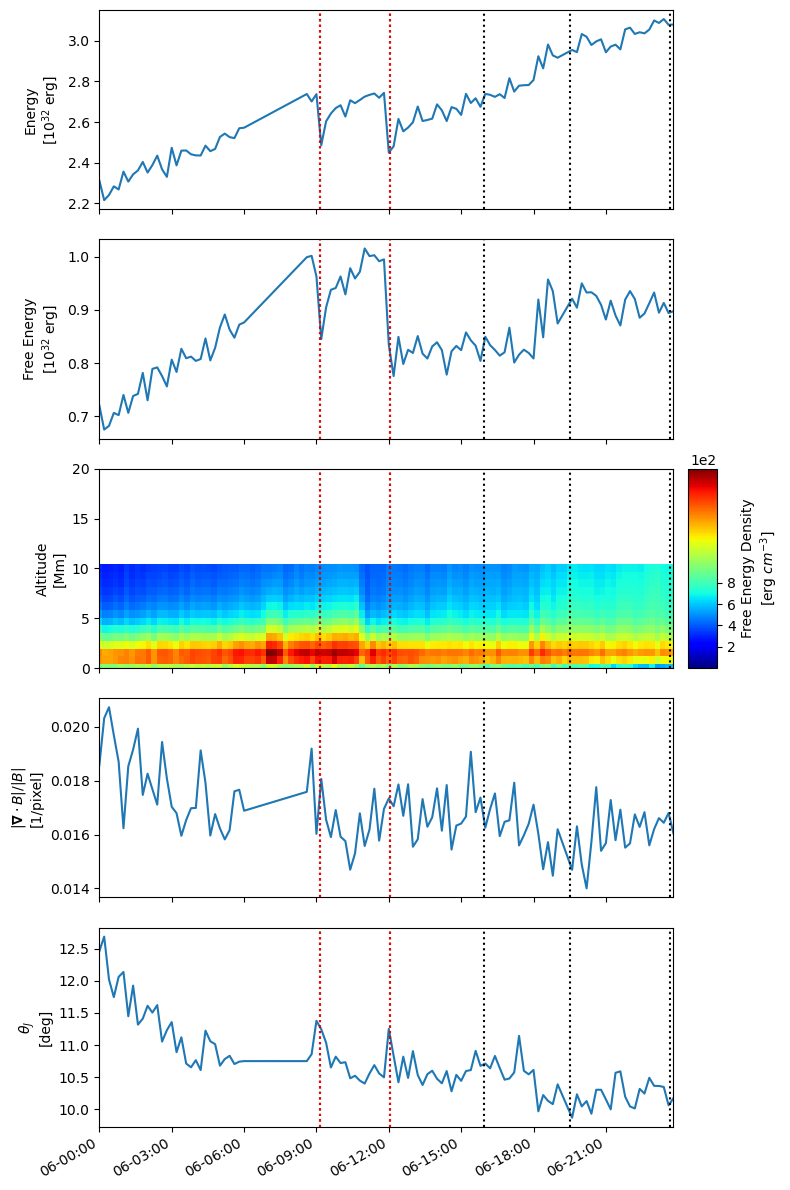

In [ ]:
x_dates = date2num(series_results['date'])
date_format = DateFormatter('%d-%H:%M')

fig, full_axs = plt.subplots(5, 2, figsize=(8, 12), gridspec_kw={"width_ratios": [1, 0.05]})
axs = full_axs[:, 0]
[ax.axis('off') for ax in full_axs[:, 1]]
# make date axis
for ax in axs:
    ax.xaxis_date()
    ax.set_xlim(x_dates[0], x_dates[-1])
    ax.xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()

ax = axs[0]
ax.plot(x_dates, np.array(series_results['total_energy']) * 1e-32)
ax.set_ylabel('Energy\n[$10^{32}$ erg]')

ax = axs[1]
ax.plot(x_dates, np.array(series_results['total_free_energy']) * 1e-32)
ax.set_ylabel('Free Energy\n[$10^{32}$ erg]')

ax = axs[2]
dt = np.diff(x_dates)[0] / 2
dz = Mm_per_pix / 2
free_energy_distribution = np.array(series_results['height_free_energy']).T
max_height = free_energy_distribution.shape[0] * Mm_per_pix
mpb = ax.imshow(free_energy_distribution,  # average
                extent=(x_dates[0] - dt, x_dates[-1] + dt, -dz, max_height + dz), aspect='auto', origin='lower',
                cmap=cm.get_cmap('jet'), vmin=0)
ax.set_ylabel('Altitude\n[Mm]')
ax.set_ylim(0, 20)

# add colorbar
full_axs[2, 1].axis('on')
cbar = fig.colorbar(mpb, cax=full_axs[2, 1], label='Free Energy Density\n' + r'[erg $cm^{-3}]$')
cbar.formatter.set_powerlimits((0, 0))
cbar.set_ticks([2e2, 4e2, 6e2, 8e2])
# full_axs[2, 1].remove()

ax = axs[3]
ax.plot(x_dates, np.array(series_results['total_div']))
ax.set_ylabel(r'$|\mathbf{\nabla} \cdot B| / |B|$' + '\n[1/pixel]')

ax = axs[4]
ax.plot(x_dates, np.array(series_results['theta']))
ax.set_ylabel(r'$\theta_J$' + '\n[deg]')

for t, goes_class in zip(flares['event_peaktime'], flares['fl_goescls']):
    flare_intensity = np.log10(float(goes_class[1:]) * goes_mapping[goes_class[0]])
    if flare_intensity >= np.log10(1 * 10 ** 2):
        [ax.axvline(x=date2num(t.datetime), linestyle='dotted', c='black') for ax in axs]
    if flare_intensity >= np.log10(1 * 10 ** 3):
        [ax.axvline(x=date2num(t.datetime), linestyle='dotted', c='red') for ax in axs]

plt.tight_layout()
plt.show()

In [ ]:
series_results.keys()

dict_keys(['date', 'b_0', 'total_energy', 'total_free_energy', 'total_div', 'total_jxb', 'theta', 'height_free_energy', 'j_map', 'energy_map', 'free_energy_map', 'jxb_map'])

In [ ]:
len(series_results['date'])

106

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable

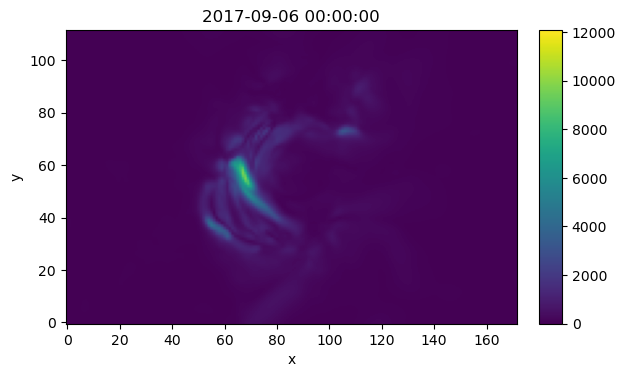

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
j_maps = np.array(series_results['j_map'])
vmax = j_maps.max()

def update(frame_number):
    cax.cla()
    im = ax.imshow(j_maps[frame_number, ...].T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='viridis')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())

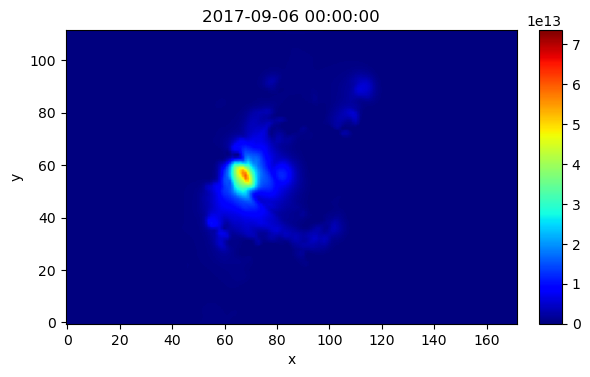

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
free_energy_maps = np.array(series_results['free_energy_map'])
vmax = free_energy_maps.max()

def update(frame_number):
    cax.cla()
    im = ax.imshow(free_energy_maps[frame_number, ...].T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='jet')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())

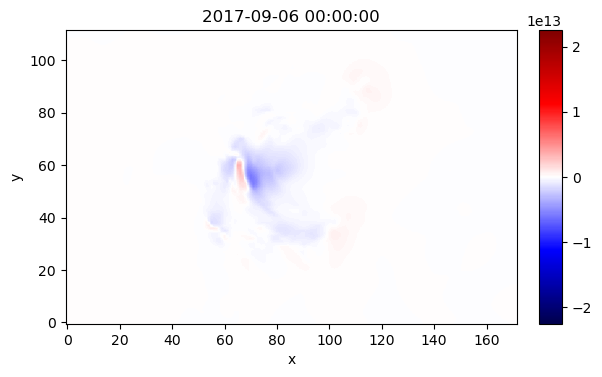

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
free_energy_change_maps = np.gradient(np.array(series_results['free_energy_map']), axis=0)
v_min_max = np.max(np.abs(free_energy_change_maps))

def update(frame_number):
    cax.cla()
    im = ax.imshow(free_energy_change_maps[frame_number, ...].T, origin='lower', 
                   norm=Normalize(vmin=-v_min_max, vmax=v_min_max), cmap='seismic')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())

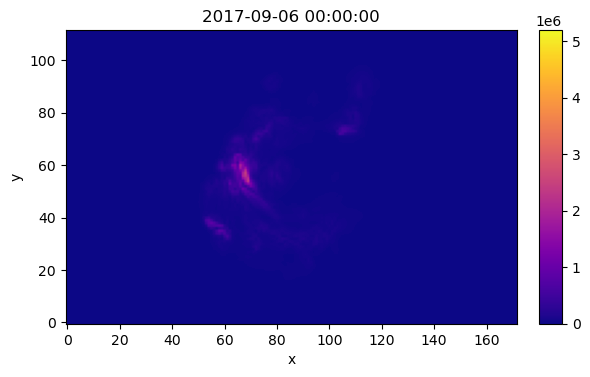

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
jxb_maps = np.array(series_results['jxb_map'])
vmax = jxb_maps.max()

def update(frame_number):
    cax.cla()
    im = ax.imshow(jxb_maps[frame_number, ...].T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='plasma')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())